In [1]:
import pandas as pd
import re
import string
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Reading the cleaned data file into a DataFrame and checking the shape
datafile = pd.read_csv('AmazonMobileDataCleaned3.csv')
print(datafile.shape)

(71909, 2)


In [3]:
#splitting label (output) and feedback(input)
label = datafile['decision_2'].values   #  output y is separated in a list called as label
feedback = datafile.drop(['decision_2'], axis = 1)    #input x is separated in form of Dataframe only called as data 
datafile.shape

(71909, 2)

In [4]:
print(type(label)), print(label.shape)

<class 'numpy.ndarray'>
(71909,)


(None, None)

In [5]:
print(type(feedback)), print(feedback.shape)

<class 'pandas.core.frame.DataFrame'>
(71909, 1)


(None, None)

In [6]:
# split data into training, testing data
from sklearn.model_selection import train_test_split   #class to split data

inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size = 0.2, stratify = label)
print("printing shapes")
print(inputtrain.shape)
print(outputtrain.shape)
print(inputtest.shape)
print(outputtest.shape)

print("---------------")
print("printing types")
print(type(inputtrain))
print(type(outputtrain))
print(type(inputtest))
print(type(outputtest))



printing shapes
(57527, 1)
(57527,)
(14382, 1)
(14382,)
---------------
printing types
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [7]:
# converting Cleaned texts (feedbacks)into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer  

vec = CountVectorizer(min_df = 10, ngram_range=(1,3))
vec.fit(inputtrain['cleanedreview_3'].values)  #fitting is done only on training data

#vec.transform(feedback['cleanedreview_3'].values)

cleanedtext_train = vec.transform(inputtrain['cleanedreview_3'].values)  #input = cleaned feedbacks
cleanedtext_test = vec.transform(inputtest['cleanedreview_3'].values)    #output = Decision (1, 0)

print("After Vectorization on input")
print("printing shapes")
print(cleanedtext_train.shape)
print(cleanedtext_test.shape)
print("output remained the same")
print(outputtrain.shape)
print(outputtest.shape)

print("---------------")
print("printing types")
print(type(cleanedtext_train))
print(type(cleanedtext_test))
print(type(outputtrain))
print(type(outputtest))

After Vectorization on input
printing shapes
(57527, 28968)
(14382, 28968)
output remained the same
(57527,)
(14382,)
---------------
printing types
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
#### Naive Bayes

In [9]:
# Packages required

import math
from sklearn import model_selection
from sklearn.model_selection  import GridSearchCV
from sklearn.naive_bayes import MultinomialNB    #it takes count into consideration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Best Parameters: {'alpha': 1}
Best Score (Accuracy) on Training data: 0.8740502765258699
Best Model : MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)
Score (Accuracy) on Testing Data: 0.8475177304964538
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0       0.014847      0.001525         0.005842        0.001028       0.0001   
1       0.013640      0.000953         0.005566        0.001179       0.0010   
2       0.012707      0.000369         0.004481        0.000199       0.0100   
3       0.013089      0.001506         0.004794        0.000519       0.1000   
4       0.010804      0.000288         0.004310        0.000153       1.0000   
5       0.011084      0.000438         0.004624        0.000551      10.0000   
6       0.011870      0.002347         0.004952        0.000707     100.0000   
7       0.014422      0.000756         0.005662        0.000903    1000.0000   
8       0.016112      0.001713         0.005678        0.0011

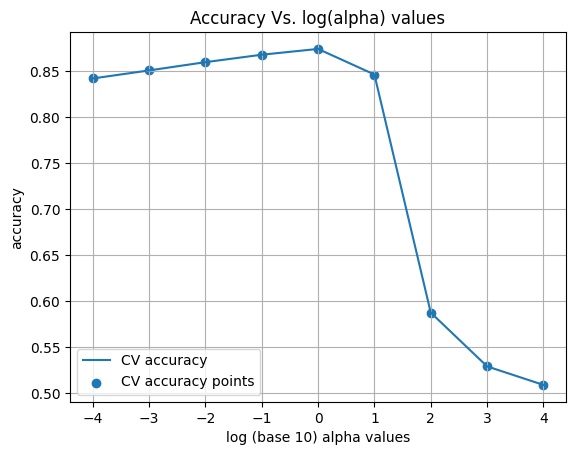

In [38]:
# Finding the Best Model (best combination of parameters)  

prior_p = [0.5,0.5]    #taking equal prior probabilities values P(Ck= 0) = P(Ck= 1) = 1/2

# Initialize the estimator (naive bayes) 
# In the context of GridSearchCV, the estimator is the model whose hyperparameters you want to optimize
naive_bayes = MultinomialNB(fit_prior= False, class_prior = prior_p) #Taking Model Multinomial

param_grid = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}   #hyper-parameter grid
# Grid is a dictionary where Keys : hyperparameter names, Values : lists of possible values. 
# (here we have only alpha in hyper-parameters) 

# Different Models M1, M2 .... means same naive_bayes model with different combinations of hyperparamters values

# Seting up the GridSearchCV 
# GridSearchCV = a grid of Models M1, M2, M3.... (naive bayes models with all possible combinations of hyper-parameters)
grid_search = GridSearchCV(naive_bayes, param_grid, cv = 5, scoring = 'roc_auc')

# Fitting the grid of models M1, M2, M3.... on training data
grid_search.fit(cleanedtext_train, outputtrain)

# Print best parameters, best score and best model
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score (Accuracy) on Training data: {grid_search.best_score_}") # Score (accuracy) from best combination of parameters (on training data)
print(f"Best Model : {grid_search.best_estimator_}")

# Evaluating accuracy of the best model (best combination of parameters)on the testing data
best_model = grid_search.best_estimator_
print(f"Score (Accuracy) on Testing Data: {best_model.score(cleanedtext_test, outputtest)}") # Score (accuracy) (on testing data)

# Access the cv_results_ attribute ( cv_results_ attribute is a dictionary that contains detailed information about the results of the grid search)
cv_results_df = pd.DataFrame.from_dict(grid_search.cv_results_)

# Printing the cv_results_ in the form of a DataFrame
cv_results_df = cv_results_df.sort_values(['param_alpha'])
print(cv_results_df)

#train_score = cv_results_df['mean_train_score']
CV_accuracy = cv_results_df['mean_test_score']
alpha_values = cv_results_df['param_alpha'] 

# alpha value is taken as log alpha value
log_alpha = []
for i in range(0,len(alpha_values)):
    log_value = math.log10(alpha_values[i])
    log_alpha.append(log_value)
    
log_alpha.sort()
print(f"log alpha values list : {log_alpha}")

#plotting accuracy (auc) Vs. alpha value
plt.plot(log_alpha, CV_accuracy, label = 'CV accuracy')   # auc = accuracy
plt.scatter(log_alpha, CV_accuracy, label = 'CV accuracy points')
plt.legend()
plt.xlabel('log (base 10) alpha values')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. log(alpha) values')
plt.grid()
plt.show()

Predicted output on Testing Data: [0 1 1 ... 1 0 0]
Predicted output as Prob. of Class 1 on Testing Data : [0.06233409 1.         0.99999998 ... 0.98211021 0.3222706  0.00981107]


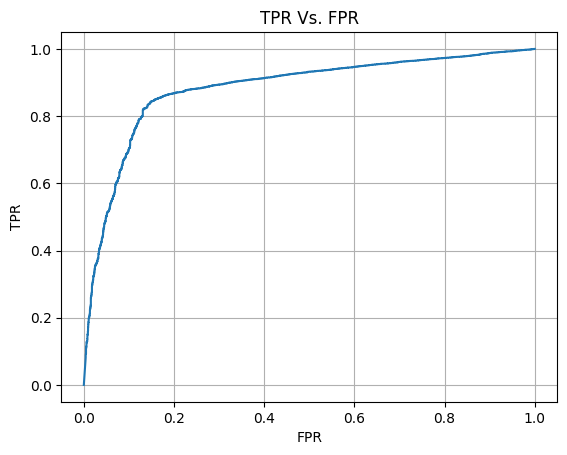

Best Threshold value T : 0.5711942390310089
Value of TPR*(1-FPR) at T : 0.7179810216335274
Predicted output on Testing Data considering Threshold T: [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1

In [59]:
# For the Best Model M1, plotting TPR Vs. FPR Curve, finding the best Threshold value T, obtaining predicted output considering Threshold T 

from sklearn.metrics import roc_curve, auc

prior_p = [0.5,0.5]    #taking equal prior probabilities values P(Ck= 0) = P(Ck= 1) = 1/2

naive_bayes_m1 = MultinomialNB(alpha = 1, fit_prior= False, class_prior = prior_p)

# Fitting the best Model M1 on training data
naive_bayes_m1.fit(cleanedtext_train, outputtrain)

#predicting output (class) , probabilities for class 1 on testing data
outputtest_pred = naive_bayes_m1.predict(cleanedtext_test)   #by default threshold value used in .predict() is 0.5
print(f"Predicted output on Testing Data: {outputtest_pred}")
outputtest_pred_prob = naive_bayes_m1.predict_proba(cleanedtext_test)[:, 1]  # ":"represnts all rows, "1" represents second column
print(f"Predicted output as Prob. of Class 1 on Testing Data : {outputtest_pred_prob}")

# Using ROC curve that gives list of Threshold values, list of TPR values, list of FPR values
FPR, TPR, Threshold = roc_curve(outputtest, outputtest_pred_prob)

#plotting ROC Curve i.e TPR Vs. FPR (corresponding to each threshold value)
plt.plot(FPR, TPR)   #in ROC auc (area under curve) represents nothing but accuracy
#plt.scatter(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('TPR Vs. FPR')
plt.grid()
plt.show()

#finding best Threshold Value T
#def best_threshold_value(FPR, TPR, Threshold):
T = Threshold[np.argmax(TPR*(1-FPR))]
print(f"Best Threshold value T : {T}")
print(f"Value of TPR*(1-FPR) at T : {max(TPR*(1-FPR))}")
    #return T

#predicting output (class) using threshold value T on testing data 
#def predict_output_using_T
outputtest_pred_using_T = []
for i in outputtest_pred_prob:
    if i >= T: 
        outputtest_pred_using_T.append(1)
    else: 
        outputtest_pred_using_T.append(0)
print(f"Predicted output on Testing Data considering Threshold T: {outputtest_pred_using_T}")
#return outputtest_pred_using_T



Confusion Matrix :
[[2457  425]
 [1815 9685]]
type of confusion matrix: <class 'numpy.ndarray'>


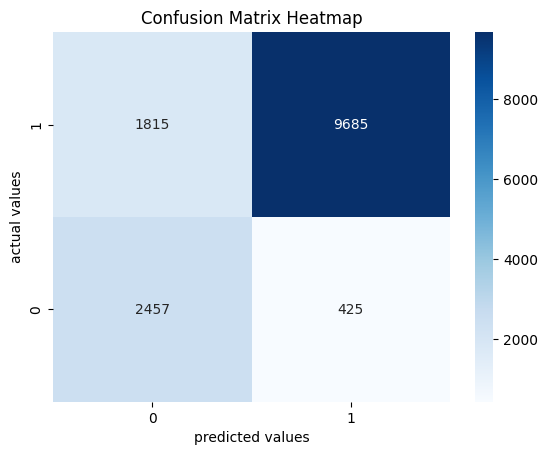

In [100]:
# For the Best Model M1, best Threshold value T, plotting confusion matrix (FPR, TPR, FNR, TNR)

from sklearn.metrics import confusion_matrix
import seaborn as sns     #for heatmap

confusionmatrix = confusion_matrix(outputtest, outputtest_pred_using_T)
print(f"Confusion Matrix :\n{confusionmatrix}")
print(f"type of confusion matrix: {type(confusionmatrix)}")   #a00 = TN , a01 = FP, a10 = FN, a11 = TP 
# Actuacl -> Vertical (0,1), Predicted -> Horizontal (0,1)

#Visualizing confusion matrix using Seaborn library's heatmap function
ax= sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='Blues')
ax.set_ylim([0,2])
#Customize the plot with additional settings from Matplotlib
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.title('Confusion Matrix Heatmap')
plt.show()

# annot=True: Adds numerical annotations to each cell in the heatmap for better readability.
# fmt='d': Specifies that the annotations should be formatted as integers.
# cmap='Blues': Specifies the color map to use for the heatmap, in this case, shades of blue.

In [110]:
# Converting imbalance data into balanced data (training data)

from sklearn.utils import resample

count_class_0, count_class_1 = datafile['decision_2'].value_counts()
print(f"class 0 pt.s : {count_class_0}")
print(f"class 1 pt.s : {count_class_1}")

df_class_0 = datafile[datafile['decision_2']==0]
df_class_1 = datafile[datafile['decision_2']==1]

df_class_0_upsampled = resample(df_class_0, replace = True, n_samples = 57499)

datafile_balanced = pd.concat([df_class_1, df_class_0_upsampled])

count_class_0_new, count_class_1_new = datafile_balanced['decision_2'].value_counts()
print(f"\nclass 0 pt.s New : {count_class_0_new}")
print(f"class 1 pt.s New : {count_class_1_new}")

class 0 pt.s : 57499
class 1 pt.s : 14410

class 0 pt.s New : 57499
class 1 pt.s New : 57499
